Day 37 : 21.03.12

# Simple Feature Engg Notebook - Spooky Author 

https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author

이 대회의 데이터셋은 다음과 같은 유명하고 무서운 저자들이 쓴 소설 작품의 텍스트를 포함한다.
1. Edgar Allen Poe (EAP)
2. HP Lovecraft (HPL)
3. Mary Wollstonecraft Shelley (MWS)

이 커널에선 무서운 작가를 식별하는 데 도움이 되는 다양한 변수를 만들어본다. 첫 단계로, feature engineering 파트에 깊이 들어가기 전, 몇 가지 기본적인 데이터 시각화 및 전처리를 수행한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
print('Number of rows in train dataset : ', train_df.shape[0])
print('Number of rows in test dataset : ', test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


In [4]:
train_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


클래스가 균형적인지 보기 위해 각 저자의 발생 횟수를 확인할 수 있다.

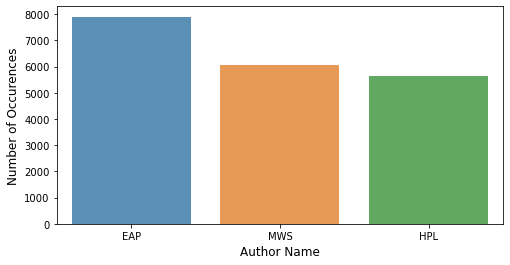

In [8]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

클래스의 불균형이 심하지 않다. 각 저자의 몇 줄씩 출력해 가능하면 그들의 작문 스타일을 이해보자.

In [9]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print('Author name : ', name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row['text'])
        cnt += 1
        if cnt == 5:
            break
    print('\n')

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

text 데이터에 특수문자가 많다는 것을 알 수 있다. 이 특수문자들이 좋은 변수일 수 있다.

그거 말고는, 단서가 많지 않다. 

## Feature engineering

이제 feature engineering을 해보자. 두 가지 주요 부분으로 구성된다.

1. Meta features : 단어 수, 중지단어 수, 문장부호 수 등과 같은 text에서 추출되는 변수
2. Text based features : 빈도, svd, word2vec 등과 같은 텍스트/단어을 직접적 기반으로 하는 변수

### Meta Features

메타 변수를 만든느 것부터 시작해 그것들이 작가를 얼마나 잘 예측하는지 볼 것이다. 다음은 변수 목록이다.
1. 텍스트의 단어 수
2. 텍스트의 고유 단어 수
3. 텍스트의 문자 수
4. 중지단어 수
5. 구두점 수
6. 대문자 수
7. 제목 수
8. 단어 평균 길이

In [16]:
# 1. 텍스트의 단어 수
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x:  len(str(x).split()))

# 2. 텍스트의 고유 단어 수
train_df['num_unique_words'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# 3. 텍스트의 문자 수
train_df['num_chars'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x: len(str(x)))

# 4. 텍스트의 중지단어 수
train_df['num_stopwords'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

# 5. 텍스트의 구두점 수
train_df['num_punctuations'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# 6. 텍스트의 대문자 수
train_df['num_words_upper'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# 7. 텍스트의 제목 수
train_df['num_words_title'] = train_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# 8. 텍스트의 단어 평균 길이
train_df['mean_word_len'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

이제 예측에 도움이 될지 보기 위해 새로운 변수 중 일부를 시각화해보자.

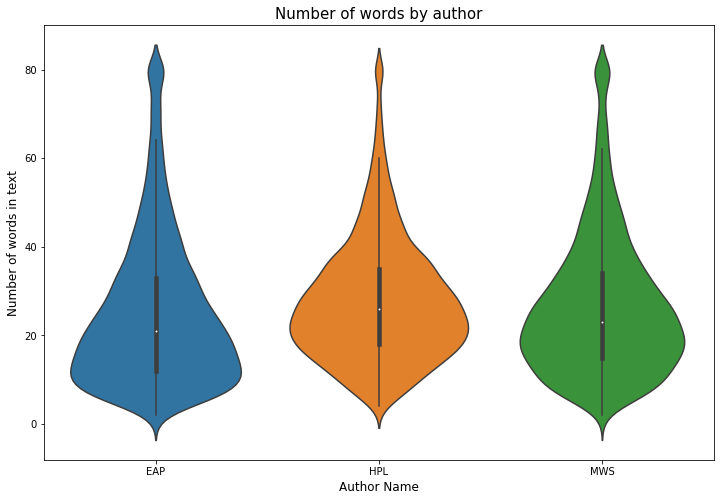

In [18]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 # 더 나은 시각화 위해
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title('Number of words by author', fontsize=15)
plt.show()

EAP는 MWS나 HPL보다 단어 수가 약간 적어보인다.

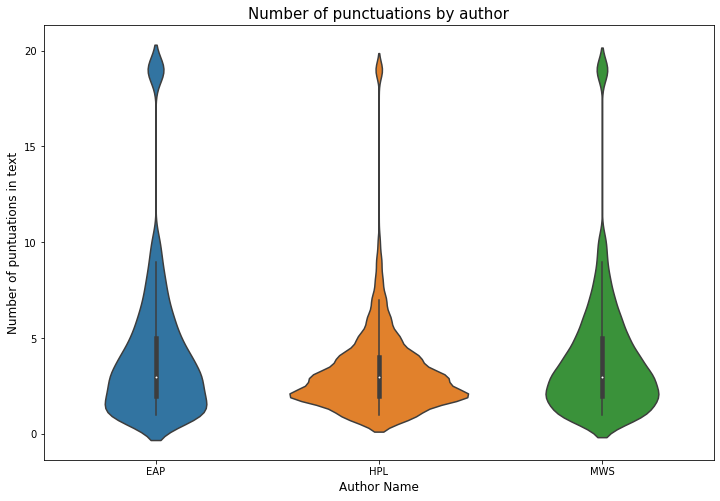

In [19]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 19
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

다소 유용해보인다. 이제 텍스트 기반 변수를 만드는 데 초점을 두자. 먼저 이렇나 메타 변수가 어떻게 도움이 되는지 볼 수 있는 기본 모델을 구축한다.

In [20]:
# 모델링 위한 데이터 준비
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

# 잘라낸 변수 다시 계산
train_df['num_words'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id','text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

이 메타 변수만으로 XGBoost를 학습시킬 수 있다.

In [24]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [(xgtrain,'train'), (xgtest,'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.Dmatrix(test_y)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit=model.best_ntree_limit)
        
    return pred_test_y, pred_test_y2, model

커널 실행 시간을 위해, 점수를 위한 k-fold 교차 검증에서 첫 폴드를 확인할 수 있다. 로컬에서 실행되는 동안 'break' 라인을 제거한다.

In [25]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print('cv scores :', cv_scores)

[22:11:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.09384	test-mlogloss:1.09472
[20]	train-mlogloss:1.04659	test-mlogloss:1.05728
[40]	train-mlogloss:1.02361	test-mlogloss:1.03854
[60]	train-mlogloss:1.01106	test-mlogloss:1.02973
[80]	train-mlogloss:0.99819	test-mlogloss:1.02001
[100]	train-mlogloss:0.98925	test-mlogloss:1.01370
[120]	train-mlogloss:0.98182	test-mlogloss:1.00884
[140]	train-mlogloss:0.97575	test-mlogloss:1.00533
[160]	train-mlogloss:0.97071	test-mlogloss:1.00279
[180]	train-mlogloss:0.96591	test-mlogloss:1.00060
[200]	train-mlogloss:0.96112	test-mlogloss:0.99808
[220]	train-mlogloss:0.95725	test-mlogloss:0.99659
[240]	trai

메타 변수만 사용해 0.987의 mlogloss을 얻었다. 나쁘지 않다. 이제 이들 중 어떤 변수가 중요한지 살펴보자.

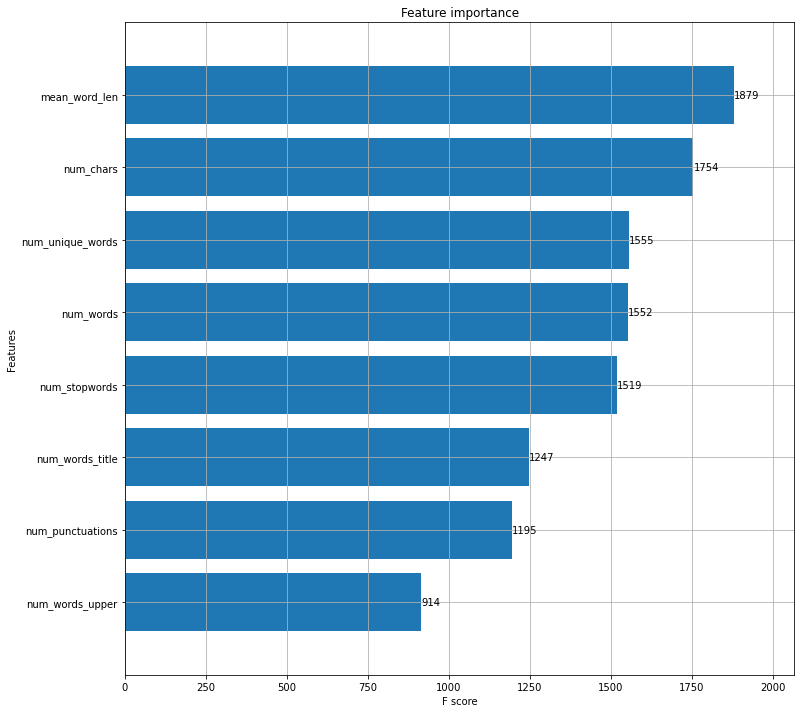

In [26]:
# 주요 변수 시각화
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

문자수, 평균 단어 길이, 고유 단어 수가 상위 3개 변수로 나타났다. 이제 텍스트 기반 변수를 만들 것이다.

텍스트 기반 변수 : 만들 수 있는 기본 변수 중 하나는 텍스트에 있는 단어의 tf-idf값이다. 그것부터 시작한다.

In [34]:
# tfidf vectorizer를 fit transform
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].to_list() + test_df['text'].tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 tfidf 벡터를 얻었는데, 까다로운 부분이 있다. tfidf 출력은 희소행렬이므로 다른 밀집변수와 함께 사용해야 한다면 몇 가지 선택사항이 있다.
1. tfidf vectorizer에서 상위 'n' 변수(시스템 구성에 따라 다름)을 가져와 밀집행렬 형식으로 변환하고 다른 변수와 합칠 수 있다.
2. 희소 변수만 사용해 모델을 만든 다음 다른 밀집 변수와 함께 예측을 변수 중 하나로 사용한다.

데이터셋을 기준으로 하면 다른 데이터셋보다 성능이 좋을 수 있다. 여기서 tfidf의 모든 변수를 사용하는 매우 좋은 커널이 있으므로 두 번째 접근법을 사용할 수 있다.

또한, Naive Bayes는 이 데이터셋에서 더 나은 성능을 보이는 것 같다. 그래서 학습이 빠르기 때문에 tfidf 변수를 사용해 naive bayes 모델을 구축할 수 있다.

In [38]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

### Navie Bayes on Word Tfidf Vectorizer

In [39]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print('Mean cv score :', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score : 0.8422161983612855


tfidf vectorizer를 사용해 0.844의 mlogloss를 얻었다. 메타 변수보다 훨씬 낫다. confusion matrix를 보자.

In [45]:
# confusion matrix 생성 함수
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion_matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, format(cm[i,j], fmt), horizontalalignment='center',
                 color='white' if cm[i,j]>thresh else 'black')
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

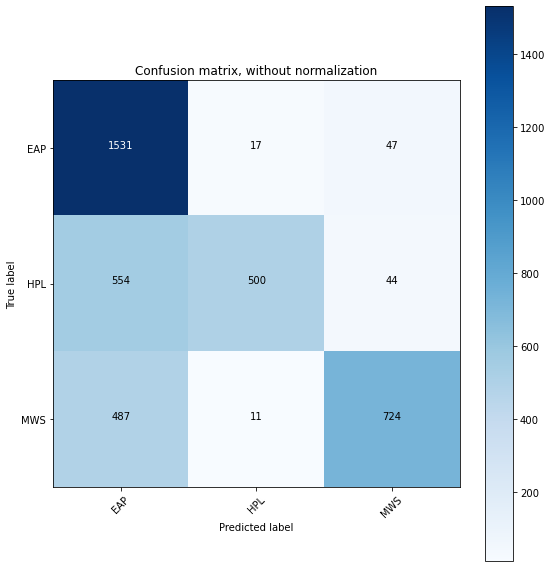

In [46]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 confusion matrix 시각화
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

많은 사례들이 EAP로 예측되고 그 클래스로 편향되어있다.

### SVD on word TFIDF

tfidf 벡터는 희소행렬이므로 정보를 압축하고 매우 컴팩트한 방법으로 표현하는 또 다른 방법은 SVD를 통하는 것이다. 단어 tfidf에 svd 변수를 만들어 변수셋에 추가할 수 있다.

In [49]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_dfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

### Naive Bayes on Word Count Vectorizer

In [51]:
# count vectorizer를 fit transform
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

이제 count vectorizer 기반 변수를 사용해 multinomialNB 모델을 구축한다.

In [52]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score :', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 새로운 변수에 예측 추가
train_df['nb_cvec_eap'] = pred_train[:,0]
train_df['nb_cvec_hpl'] = pred_train[:,1]
train_df['nb_cvec_mws'] = pred_train[:,2]
test_df['nb_cvec_eap'] = pred_full_test[:,0]
test_df['nb_cvec_hpl'] = pred_full_test[:,1]
test_df['nb_cvec_mws'] = pred_full_test[:,2]

Mean cv score : 0.45091841616567435


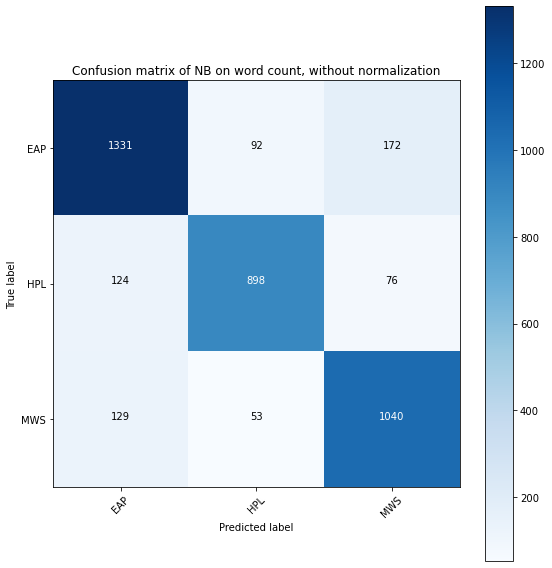

In [54]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 confusion matrix 시각화
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

tfidf vectorizer 대신 count vectorizer를 사용해 0.451의 교차검증 mlogloss를 얻었다.이 모델을 사용한 LB 점수는 0.468이다. 또한 confusion matrix가 이전보다 훨씬 좋아보인다.

### Naive Bayes on Character Count Vectorizer

'data eyeballing'의 한 아이디어는 특수문자를 세는 것이다. 특수문자만 세는 대신 문자 수준의 count vectorizer를 사용해 몇 가지 변수를 얻을 수 있다. 거기에 Multinomail NB를 실행시킨다.

In [55]:
# tfidf vectorizer를 fit transform
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 새 변수로 예측 추가
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


교차검증(cv) 점수가 3.75로 아주 높다. 그러나 이는 단어 수준 변수와 다른 정보를 추가할 수 있으므로 최종 모델에도 사용할 수 있다.

### Naive Bayes on Character Tfidf Vectorizer

문자 tfidf vectorizer에 naive bayes 예측도 해보자.

In [59]:
# tfidf vectorizer를 fit transform
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# 예측을 새로운 변수로 추가
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


### SVD on Charater TFIDF

In [60]:
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

### XGBoost model

이제 이 새로운 변수로 xgboost 모델을 재실행하고 결과를 평가할 수 있다.

In [61]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[22:53:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:1.00354	test-mlogloss:1.00354
[20]	train-mlogloss:0.40979	test-mlogloss:0.41471
[40]	train-mlogloss:0.33861	test-mlogloss:0.35066
[60]	train-mlogloss:0.31310	test-mlogloss:0.33273
[80]	train-mlogloss:0.29583	test-mlogloss:0.32381
[100]	train-mlogloss:0.28281	test-mlogloss:0.31811
[120]	train-mlogloss:0.27173	test-mlogloss:0.31396
[140]	train-mlogloss:0.26200	test-mlogloss:0.31138
[160]	train-mlogloss:0.25348	test-mlogloss:0.31012
[180]	train-mlogloss:0.24571	test-mlogloss:0.30896
[200]	train-mlogloss:0.23812	test-mlogloss:0.30830
[220]	train-mlogloss:0.23138	test-mlogloss:0.30716
[240]	trai

검증 점수가 0.18775고 LB점수가 0.30628다. 모든 폴드에서 실행하면 더 좋은 점수를 얻을 수 있다. 이제 주요 변수들을 다시 확인해보자.

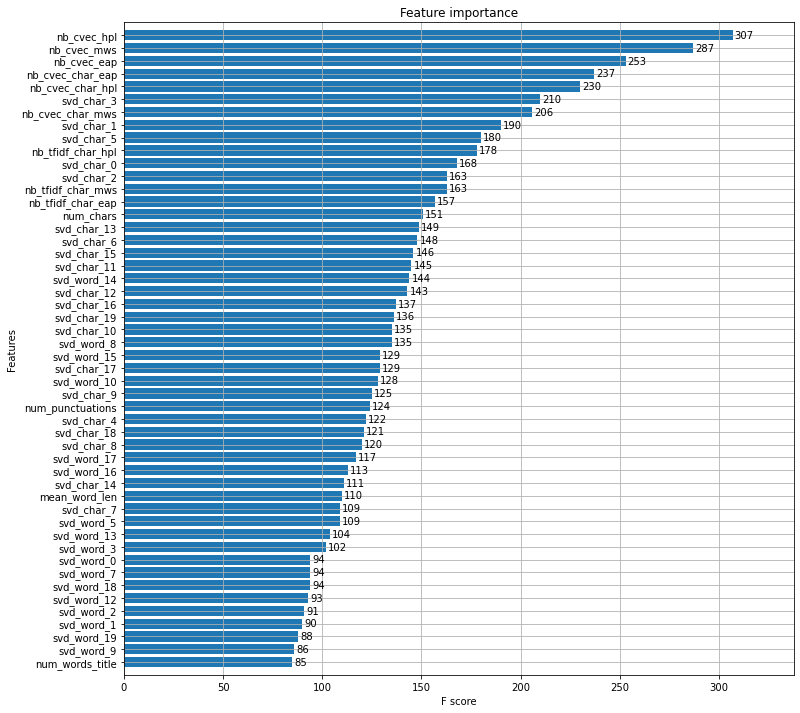

In [62]:
# 주요 변수 시각화
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

navie bayes 변수가 예상대로 최고 변수다. 이제 confusion matrix를 통해 오분류 오류를 살펴보자.

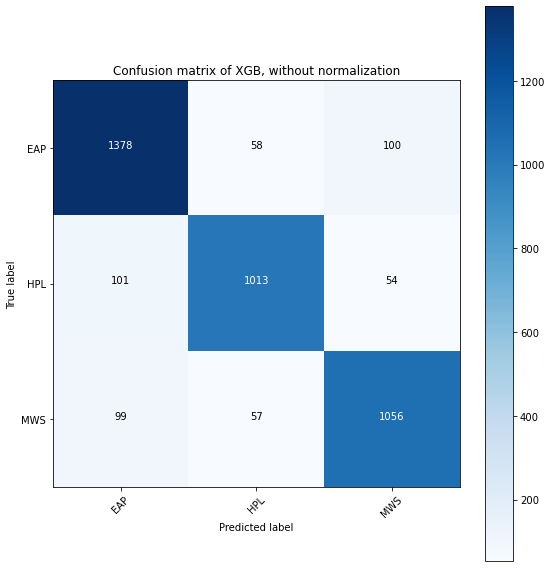

In [64]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y, axis=1))
np.set_printoptions(precision=2)

# 정규화되지 않은 confusion matrix 시각화
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP','HPL','MWS'],
                     title='Confusion matrix of XGB, without normalization')
plt.show()

EAP와 MWS는 오분류가 더 많다. 잠재적으로 이 쌍에 대한 예측을 개선하는 변수를 만들 수 있다.